In [1]:
# filename: knn.ipynb
# purpose: knn model implemenation

# OHT knn model implementation 

### KNN implementation method 
- aaa

### Processing flow
- aaa

In [2]:
# packages
import time
import pathlib
import numpy as np
import pandas as pd

import humanfriendly as human

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

# Plotting decision boundaries
from matplotlib.colors import ListedColormap

import ohtconf as conf
import ohtcomm as comm

## Main

In [3]:
mainstart = time.time()

In [4]:
# read table data
_start = time.time()

dfmix = comm.read_tabdf(conf.TABNAME_MIX)
dfmix.sort_values(by=conf.COLUMN_NAMES[0], inplace=True)
dfmix.reset_index(drop=True, inplace=True)

dfknn = dfmix.iloc[0 : conf.TRAIN_SIZE]  # execution time key factor

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

elapsed time: 0.1 seconds


In [5]:
USESCALE = False  # no big difference between feature scaling or not

### KNN with all, 10 fetures

In [6]:
_start = time.time()

# Split features and label
X = dfknn.loc[:, conf.COLUMN_GRAPH]
y = dfknn[conf.COLUMN_FLAG]  # series for 1-d array

# Feature scaling
if USESCALE:
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=conf.COLUMN_GRAPH)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

elapsed time: 0.01 seconds


In [7]:
# check data
if 1 == 1:
    print(f"data type X={type(X)}, X_train={type(X_train)}, y_train={type(y_train)}")
    print(f"X_train={X_train[:3]}")
    print(f"X_test={X_test[:3]}")
    print(f"y_train={y_train[:3]}")
    print(f"y_test={y_test[:3]}")

data type X=<class 'pandas.core.frame.DataFrame'>, X_train=<class 'pandas.core.frame.DataFrame'>, y_train=<class 'pandas.core.series.Series'>
X_train=        TEM  PM1  PM2_5  PM10   CO  NH3  CT1  CT2  CT3  CT4
77889  40.5   10     12    13  162   88  0.9  1.0  0.4  0.6
81446  40.5   13     13    15  161   88  0.8  4.8  0.5  0.5
2767   40.8   10     12    13  164   88  0.8  1.1  0.5  0.5
X_test=        TEM  PM1  PM2_5  PM10   CO  NH3  CT1  CT2  CT3  CT4
36349  40.6   13     13    15  162   89  0.9  1.0  0.4  0.5
9845   40.6   10     12    13  161   89  0.8  1.1  0.4  4.9
47263  40.5   13     13    15  167   89  0.9  1.0  0.5  0.5
y_train=77889    0
81446    8
2767     0
Name: FLAG, dtype: int64
y_test=36349     0
9845     10
47263     0
Name: FLAG, dtype: int64


In [8]:
_start = time.time()

# Create KNN classifier
knn = KNeighborsClassifier()

# Grid search for optimal K value
param_grid = {"n_neighbors": conf.N_NEIGHBORS}
print(f"param_grid={param_grid}")

# K-fold Cross-Validation: Divide the dataset into K folds. Train the model on K-1 folds and evaluate on the remaining fold.
# Repeat this K times, rotating the validation fold.
grid_search = GridSearchCV(knn, param_grid, cv=4, verbose=3)  # cv for cross validator folds
grid_search.fit(X_train, y_train)

# Best K value
best_k = grid_search.best_params_["n_neighbors"]
print(f"best_k={best_k} on param_grid={param_grid}")

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

param_grid={'n_neighbors': range(2, 9)}
Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END .....................n_neighbors=2;, score=0.950 total time=   1.4s
[CV 2/4] END .....................n_neighbors=2;, score=0.953 total time=   1.3s
[CV 3/4] END .....................n_neighbors=2;, score=0.948 total time=   1.5s
[CV 4/4] END .....................n_neighbors=2;, score=0.951 total time=   1.4s
[CV 1/4] END .....................n_neighbors=3;, score=0.951 total time=   1.4s
[CV 2/4] END .....................n_neighbors=3;, score=0.953 total time=   1.5s
[CV 3/4] END .....................n_neighbors=3;, score=0.949 total time=   1.5s
[CV 4/4] END .....................n_neighbors=3;, score=0.951 total time=   1.5s
[CV 1/4] END .....................n_neighbors=4;, score=0.950 total time=   1.5s
[CV 2/4] END .....................n_neighbors=4;, score=0.952 total time=   1.5s
[CV 3/4] END .....................n_neighbors=4;, score=0.948 total time=   1.4s
[CV 4/4] 

In [9]:
_start = time.time()

# Final model with best K
final_model = KNeighborsClassifier(n_neighbors=best_k)
final_model.fit(X_train, y_train)

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

elapsed time: 0.15 seconds


In [10]:
_start = time.time()

# Predictions
y_pred = final_model.predict(X_test)

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

elapsed time: 1.96 seconds


In [11]:
# Accuracy score
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.9524537037037037

Confusion Matrix:
 [[15941    48     4     0    27    21    14    22    10    39    37]
 [  125   414     1     0     0     0     0     0     0     0     0]
 [   19     0   493     0     0     0     0     0     0     0     0]
 [   26     0     0   512     0     0     0     0     0     0     0]
 [   58     0     1     0   489     0     0     0     0     0     0]
 [   73     1     0     0     0   490     0     0     0     0     1]
 [   92     0     0     0     0     0   478     1     0     0     0]
 [  108     0     0     0     0     1     0   431     0     0     0]
 [   91     0     0     0     0     0     0     0   451     1     0]
 [   98     0     0     0     0     0     0     0     0   440     0]
 [  107     0     0     0     0     0     0     0     0     1   434]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     16163
           1       0.89      0.77      0.83       5

### KNN with selected 2 fetures for 2-D visualization 

In [12]:
_start = time.time()

# Choose 2 fetures.  considered PCA feature reducing method, but choose 2 fetures after correlation matrix heatmap analysis
COLUMN_NAMES_KNN = [conf.COLUMN_NAMES[1], conf.COLUMN_NAMES[6]]
COLUMN_FLAGS_KNN = [1, 6]
X = dfknn.loc[:, COLUMN_NAMES_KNN]  # TEM, NH3

# Update label, flag for 2 features
y = dfknn.loc[:, [conf.COLUMN_FLAG]]
y.loc[(y[conf.COLUMN_FLAG] != COLUMN_FLAGS_KNN[0]) & (y[conf.COLUMN_FLAG] != COLUMN_FLAGS_KNN[1]), conf.COLUMN_FLAG] = (
    0  # clear other column flag
)
y = y[conf.COLUMN_FLAG]  # series for 1-d array

# Feature scaling
if USESCALE:
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=COLUMN_NAMES_KNN)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

elapsed time: 0.01 seconds


In [13]:
_start = time.time()

# Create KNN classifier
knn = KNeighborsClassifier()

# Grid search for optimal K value
param_grid = {"n_neighbors": conf.N_NEIGHBORS}
print(f"param_grid={param_grid}")

# K-fold Cross-Validation: Divide the dataset into K folds. Train the model on K-1 folds and evaluate on the remaining fold.
# Repeat this K times, rotating the validation fold.
grid_search = GridSearchCV(knn, param_grid, cv=4, verbose=3)  # cv for cross validator folds
grid_search.fit(X_train, y_train)

# Best K value
best_k = grid_search.best_params_["n_neighbors"]
print(f"best_k={best_k} on param_grid={param_grid}")

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

param_grid={'n_neighbors': range(2, 9)}
Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END .....................n_neighbors=2;, score=0.988 total time=   2.1s
[CV 2/4] END .....................n_neighbors=2;, score=0.988 total time=   2.1s
[CV 3/4] END .....................n_neighbors=2;, score=0.986 total time=   2.1s
[CV 4/4] END .....................n_neighbors=2;, score=0.988 total time=   2.3s
[CV 1/4] END .....................n_neighbors=3;, score=0.988 total time=   2.2s
[CV 2/4] END .....................n_neighbors=3;, score=0.983 total time=   1.9s
[CV 3/4] END .....................n_neighbors=3;, score=0.986 total time=   1.9s
[CV 4/4] END .....................n_neighbors=3;, score=0.989 total time=   2.0s
[CV 1/4] END .....................n_neighbors=4;, score=0.988 total time=   2.1s
[CV 2/4] END .....................n_neighbors=4;, score=0.988 total time=   2.0s
[CV 3/4] END .....................n_neighbors=4;, score=0.986 total time=   2.0s
[CV 4/4] 

In [14]:
_start = time.time()

# Final model with best K
final_model = KNeighborsClassifier(n_neighbors=best_k)
final_model.fit(X_train, y_train)

_elapsed = time.time() - _start
print(f"Rea elapsed time: {human.format_timespan(_elapsed)}")

Rea elapsed time: 0.04 seconds


In [15]:
_start = time.time()

# Predictions
y_pred = final_model.predict(X_test)

_elapsed = time.time() - _start
print(f"Rea elapsed time: {human.format_timespan(_elapsed)}")

Rea elapsed time: 2.43 seconds


In [16]:
# Accuracy score
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.9878703703703704

Confusion Matrix:
 [[20465     5    19]
 [  150   390     0]
 [   87     1   483]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     20489
           1       0.98      0.72      0.83       540
           6       0.96      0.85      0.90       571

    accuracy                           0.99     21600
   macro avg       0.98      0.86      0.91     21600
weighted avg       0.99      0.99      0.99     21600



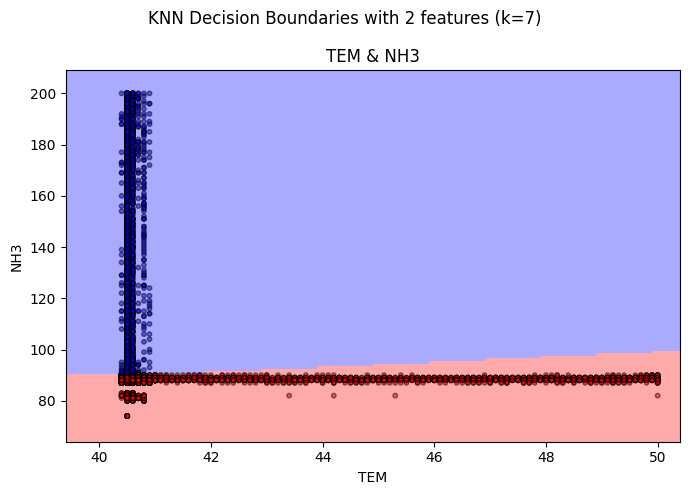

In [20]:
# Visualize KNN Decision boundaries

# Create a mesh grid for plotting decision boundaries
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 10, X.iloc[:, 1].max() + 10
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1))

# Predict the class for each point in the mesh grid
# xx.ravel() - return flattened array
# np.c_[array,array] - translates slice objects to concatenation along the second axis.
dfgrid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=COLUMN_NAMES_KNN)
Z = final_model.predict(dfgrid)
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
cmap_bold = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=conf.PLOTSIZE)
ax.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot the training points
# c=y - sequence of n numbers to be mapped to colors using *cmap*
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold, edgecolor="k", s=10, alpha=0.5)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel(COLUMN_NAMES_KNN[0])
ax.set_ylabel(COLUMN_NAMES_KNN[1])
ax.set_title(" & ".join(COLUMN_NAMES_KNN))

fig.suptitle(f"KNN Decision Boundaries with 2 features (k={best_k})")

plt.tight_layout()
plt.show()

pngfile = "knn-scatter-" + "-".join(COLUMN_NAMES_KNN) + ".png"
if pngfile is not None:
    pngfile = pngfile.lower()
    filepath = pathlib.Path(conf.DIRCHART) / pngfile
    fig.savefig(
        filepath,
        dpi=conf.DPI,
        facecolor="w",
        edgecolor="w",
        orientation="portrait",
        format=None,
        transparent=False,
        bbox_inches=None,
        pad_inches=None,
    )